# In this file we will analyze the data and create a recommendation system based on the data. We will use the RFM model to segment the customers and create a recommendation system based on the segmentation.

### Then we create  a system that will group the customers together and save the data to a csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
import random
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
data_events = pd.read_csv("processed_data/processed_events_final.csv", sep="|")
purchase_events = pd.read_csv("processed_data/purchase_data_with_categories.csv", sep="|")


In [4]:
data_events

TIMESTAMP_EVENT    PRICE  PROPOSITION  USER_CLIENT_NUMBER  \
0        2022-02-28T14:51:25.349Z  25.4760       554657              386730   
1        2022-02-28T14:51:46.443Z  25.4760       554657              386730   
2        2022-02-28T14:52:06.207Z  25.4760       554657              386730   
3        2022-02-28T14:52:06.211Z  12.5268       349240              386730   
4        2022-02-28T14:51:25.319Z  12.5268       349240              386730   
...                           ...      ...          ...                 ...   
9935804  2022-01-28T15:48:08.723Z  35.7192        87264              804960   
9935805  2022-01-28T15:46:27.480Z  17.1204       594422              804960   
9935806  2022-01-28T15:48:43.837Z  18.2424         8749              804960   
9935807  2022-01-28T15:48:53.241Z   1.6500       255956              804960   
9935808  2022-01-28T15:48:26.590Z  13.9260        70147              804960   

        ARTICLE_CATEGORIE  USER_SESSION_ID PROMOTION_LABEL      PAGE_NAME  \
0           1,081,511,193              933           Actie  Shopping Cart   
1           1,081,511,193              933           Actie  Shopping Cart   
2           1,081,511,193              933           Actie  Shopping Cart   
3           1,091,661,078              933           Actie  Shopping Cart   
4           1,091,661,078              933           Actie  Shopping Cart   
...                   ...              ...             ...            ...   
9935804     1,081,451,429           319213             NaN            NaN   
9935805     1,011,031,135           319213             NaN            NaN   
9935806     1,011,011,555           319213             NaN            NaN   
9935807     1,031,161,491           319213             NaN            NaN   
9935808     1,081,531,093           319213             NaN            NaN   

                 PAGE_SECTION  PAGE_SECTION_POSITION  ...  \
0        Recommended Products                    2.0  ...   
1        Recommended Products                    2.0  ...   
2        Recommended Products                    2.0  ...   
3        Recommended Products                    1.0  ...   
4        Recommended Products                    1.0  ...   
...                       ...                    ...  ...   
9935804                   NaN                    NaN  ...   
9935805                   NaN                    NaN  ...   
9935806                   NaN                    NaN  ...   
9935807                   NaN                    NaN  ...   
9935808                   NaN                    NaN  ...   

         precipitation_coverage_lead_2 precipitation_amount_lead_2  \
0                                  0.0                         0.0   
1                                  0.0                         0.0   
2                                  0.0                         0.0   
3                                  0.0                         0.0   
4                                  0.0                         0.0   
...                                ...                         ...   
9935804                            NaN                         NaN   
9935805                            NaN                         NaN   
9935806                            NaN                         NaN   
9935807                            NaN                         NaN   
9935808                            NaN                         NaN   

        temperature_lead_3 precipitation_coverage_lead_3  \
0                      2.9                           0.0   
1                      2.9                           0.0   
2                      2.9                           0.0   
3                      2.9                           0.0   
4                      2.9                           0.0   
...                    ...                           ...   
9935804                NaN                           NaN   
9935805                NaN                           NaN   
9935806                NaN    

In [5]:
data_events['TIMESTAMP_EVENT'] = pd.to_datetime(data_events['TIMESTAMP_EVENT'])
purchase_events['DATE'] = pd.to_datetime(purchase_events['DATE'])




 Feature Engineering
segmentation:

Recency (R): Time since last purchase.
Frequency (F): Total number of purchases.
Monetary (M): Total spending.

In [6]:
# Group by user and aggregate data
user_data = purchase_events.groupby('USER_CLIENT_NUMBER').agg({
    'DATE': 'max',  # Most recent purchase date
    'PROPOSITION': 'count',  # Frequency of purchases
    'AMOUNT': 'sum'  # Total amount spent
}).rename(columns={'DATE': 'Recent_Purchase_Date', 'PROPOSITION': 'Total_Purchases', 'AMOUNT': 'Total_Spent'})

# Calculate recency in days from the most recent date in the dataset
most_recent_date = purchase_events['DATE'].max()
user_data['Recency'] = (most_recent_date - user_data['Recent_Purchase_Date']).dt.days


In [7]:
user_data

Recent_Purchase_Date  Total_Purchases  Total_Spent  Recency
USER_CLIENT_NUMBER                                                            
193                          2022-04-21               24      2164.09      250
230                          2022-04-28              214      8049.98      243
272                          2022-04-26              241      6681.66      245
436                          2022-04-27              532     16332.51      244
467                          2022-03-16               19       611.19      286
...                                 ...              ...          ...      ...
999500                       2022-04-26              566     15555.98      245
999513                       2022-04-21               38       502.14      250
999551                       2022-02-24                3        91.40      306
999744                       2022-04-26              486     25077.71      245
999858                       2022-03-11               68      3921.83      291

[10711 rows x 4 columns]

In [8]:
# Customer Segmentation: quantile-based segmentation method 

# Use quantiles to segment each RFM feature
quantiles = user_data[['Recency', 'Total_Purchases', 'Total_Spent']].quantile(q=[0.25, 0.5, 0.75])
def rfm_segment(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

user_data['R_Score'] = user_data['Recency'].apply(rfm_segment, args=('Recency', quantiles))
user_data['F_Score'] = user_data['Total_Purchases'].apply(rfm_segment, args=('Total_Purchases', quantiles))
user_data['M_Score'] = user_data['Total_Spent'].apply(rfm_segment, args=('Total_Spent', quantiles))


With segmented data, analyze patterns and develop targeted marketing strategies:

High Value Customers: Top RFM scores. Develop loyalty programs or premium offers.
At-Risk Customers: High monetary and frequency scores but low recency score. Re-engage with personalized promotions.
Low-Value Customers: Low scores across RFM. Explore up-sell and cross-sell opportunities to increase their value.

In [9]:
# Define a simple function to assign recommendations based on RFM scores
def assign_recommendations(row):
    if row['R_Score'] == 4 and row['F_Score'] == 4 and row['M_Score'] == 4:
        return 'Premium Product Line'
    elif row['R_Score'] == 1 and row['F_Score'] >= 3:
        return 'Re-engagement Campaign'
    else:
        return 'Regular Promotions'

user_data['Recommendations'] = user_data.apply(assign_recommendations, axis=1)


In [10]:
import json
def save_each_user_in_json_per_recommendation_type(user_data):
    json_data = {
        "Re-engagement Campaign": [],
        "Regular Promotions": [],
        "Premium Product Line": []
    }
    for recommendation_type in user_data['Recommendations'].unique():
        
        json_data[recommendation_type] = user_data[user_data['Recommendations'] == recommendation_type].index.to_list()
        
    return json_data

def write_json_to_file(json_data, file_path):
    with open(file_path, 'w') as f:
        json.dump(json_data, f)
        
        
json_date_recommendations = save_each_user_in_json_per_recommendation_type(user_data)
write_json_to_file(json_date_recommendations, "processed_data/user_recommendations_types.json")

In [15]:
def get_client_data_by_id(client_id):
    
    client_events = pd.read_csv(f"client_data/{str(client_id)}/events.csv", sep="|")
    client_purchase_events = pd.read_csv(f"client_data/{str(client_id)}/purchases.csv", sep="|")
    return client_events, client_purchase_events

def get_client_data_subset_recommendation_type(recommendation_json_clients):
    for recommendation_type, client_id_list in recommendation_json_clients.items():
        for index, client_id in enumerate(client_id_list):
            
            if index == 0:
                all_client_events, all_purchase_events = get_client_data_by_id(client_id)
                continue
                
            client_events, client_purchase_events = get_client_data_by_id(client_id)
            all_client_events = pd.concat([all_client_events, client_events])
            all_purchase_events = pd.concat([all_purchase_events, client_purchase_events])
    return all_client_events, all_purchase_events

#take a subset of clients of each recommendation type
json_data_recommendation_subset = {key: value[:10] for key, value in json_date_recommendations.items()}


all_client_events, all_purchase_events = get_client_data_subset_recommendation_type(json_data_recommendation_subset)
all_client_events


TIMESTAMP_EVENT    PRICE  PROPOSITION  USER_CLIENT_NUMBER  \
0     2021-12-01T13:24:27.131Z      NaN       533300               14061   
1     2021-12-01T13:24:27.122Z      NaN       210833               14061   
2     2021-12-01T13:24:27.125Z      NaN       884210               14061   
3     2021-12-01T13:22:25.391Z   7.3128        96325               14061   
4     2021-12-01T13:23:34.821Z   4.2504       836996               14061   
...                        ...      ...          ...                 ...   
4884  2022-03-21T12:59:17.755Z      NaN       310114              183124   
4885  2022-03-21T12:59:10.990Z   6.0720       268532              183124   
4886  2022-03-21T12:59:14.263Z   6.0720       268532              183124   
4887  2022-03-21T12:59:05.634Z   6.0720       268532              183124   
4888  2022-03-21T12:59:17.766Z  18.9552       322925              183124   

     ARTICLE_CATEGORIE  USER_SESSION_ID PROMOTION_LABEL      PAGE_NAME  \
0        1,081,531,502              342             NaN  Shopping Cart   
1        1,051,201,537              342             NaN  Shopping Cart   
2        1,081,531,502              342             NaN  Shopping Cart   
3        1,091,601,549              342             NaN   Purchaselist   
4        1,091,541,028              342             NaN   Purchaselist   
...                ...              ...             ...            ...   
4884     1,043,111,060           348840             NaN  Shopping Cart   
4885           111,207           348840             NaN            NaN   
4886           111,207           348840             NaN            NaN   
4887           111,207           348840             NaN            NaN   
4888     1,081,531,334           348840             NaN  Shopping Cart   

              PAGE_SECTION  PAGE_SECTION_POSITION  ...  \
0     Recommended Products                    2.0  ...   
1     Recommended Products                    3.0  ...   
2     Recommended Products                    1.0  ...   
3     Recommended Products                    1.0  ...   
4     Recommended Products                    4.0  ...   
...                    ...                    ...  ...   
4884  Recommended Products                    2.0  ...   
4885                   NaN                    NaN  ...   
4886                   NaN                    NaN  ...   
4887                   NaN                    NaN  ...   
4888  Recommended Products                    3.0  ...   

      precipitation_coverage_lead_2 precipitation_amount_lead_2  \
0                               NaN                         NaN   
1                               NaN                         NaN   
2                               NaN                         NaN   
3                               NaN                         NaN   
4                               NaN                         NaN   
...                             ...                         ...   
4884                            0.0                         0.0   
4885                            0.0                         0.0   
4886                            0.0                         0.0   
4887                            0.0                         0.0   
4888                            0.0                         0.0   

     temperature_lead_3 precipitation_coverage_lead_3  \
0                   NaN                           NaN   
1                   NaN                           NaN   
2                   NaN                           NaN   
3                   NaN                           NaN   
4                   NaN                           NaN   
...                 ...                           ...   
4884                9.4                           0.0   
4885                9.4                           0.0   
4886                9.4                           0.0   
4887                9.4                           0.0   
4888                9.4                           0.0   

     precipitation_amount_

# The clients we use for analysis 

In [22]:
json_data_recommendation_subset

{'Re-engagement Campaign': [436,
  545,
  1423,
  1489,
  1544,
  1597,
  1780,
  1923,
  2005,
  2288],
 'Regular Promotions': [193, 230, 272, 467, 500, 549, 695, 706, 716, 840],
 'Premium Product Line': [14061,
  22581,
  70951,
  91935,
  108385,
  131998,
  139557,
  158320,
  176301,
  183124]}

In [23]:
with open("chosen_client_id_json_recommendation_type.json", "w") as file:
    file.write(json.dumps(json_data_recommendation_subset))

In [12]:
# dropping all rows that have page_section_postion as NaN
recommended_products_table = all_client_events[all_client_events["PAGE_SECTION"] =="Recommended Products"]
recommended_products_table["USER_SALES_DISTRICT"].unique()
recommended_products_table

TIMESTAMP_EVENT    PRICE  PROPOSITION  USER_CLIENT_NUMBER  \
0     2021-12-01T13:24:27.131Z      NaN       533300               14061   
1     2021-12-01T13:24:27.122Z      NaN       210833               14061   
2     2021-12-01T13:24:27.125Z      NaN       884210               14061   
3     2021-12-01T13:22:25.391Z   7.3128        96325               14061   
4     2021-12-01T13:23:34.821Z   4.2504       836996               14061   
...                        ...      ...          ...                 ...   
4849  2022-03-20T11:41:30.020Z  18.9552       322925              183124   
4855  2022-03-20T11:41:20.664Z      NaN       974246              183124   
4883  2022-03-21T12:59:17.756Z      NaN       500773              183124   
4884  2022-03-21T12:59:17.755Z      NaN       310114              183124   
4888  2022-03-21T12:59:17.766Z  18.9552       322925              183124   

     ARTICLE_CATEGORIE  USER_SESSION_ID PROMOTION_LABEL      PAGE_NAME  \
0        1,081,531,502              342             NaN  Shopping Cart   
1        1,051,201,537              342             NaN  Shopping Cart   
2        1,081,531,502              342             NaN  Shopping Cart   
3        1,091,601,549              342             NaN   Purchaselist   
4        1,091,541,028              342             NaN   Purchaselist   
...                ...              ...             ...            ...   
4849     1,081,531,334           345503             NaN  Shopping Cart   
4855     1,101,711,010           345503             NaN  Purchase List   
4883     1,091,661,305           348840             NaN  Shopping Cart   
4884     1,043,111,060           348840             NaN  Shopping Cart   
4888     1,081,531,334           348840             NaN  Shopping Cart   

              PAGE_SECTION  PAGE_SECTION_POSITION  ...  \
0     Recommended Products                    2.0  ...   
1     Recommended Products                    3.0  ...   
2     Recommended Products                    1.0  ...   
3     Recommended Products                    1.0  ...   
4     Recommended Products                    4.0  ...   
...                    ...                    ...  ...   
4849  Recommended Products                    4.0  ...   
4855  Recommended Products                    3.0  ...   
4883  Recommended Products                    1.0  ...   
4884  Recommended Products                    2.0  ...   
4888  Recommended Products                    3.0  ...   

      precipitation_coverage_lead_2 precipitation_amount_lead_2  \
0                               NaN                         NaN   
1                               NaN                         NaN   
2                               NaN                         NaN   
3                               NaN                         NaN   
4                               NaN                         NaN   
...                             ...                         ...   
4849                            0.0                         0.0   
4855                            0.0                         0.0   
4883                            0.0                         0.0   
4884                            0.0                         0.0   
4888                            0.0                         0.0   

     temperature_lead_3 precipitation_coverage_lead_3  \
0                   NaN                           NaN   
1                   NaN                           NaN   
2                   NaN                           NaN   
3                   NaN                           NaN   
4                   NaN                           NaN   
...                 ...                           ...   
4849                9.7                           0.0   
4855                9.7                           0.0   
4883                9.4                           0.0   
4884                9.4                           0.0   
4888                9.4                           0.0   

     precipitation_amount_

In [13]:
def get_product_session_columns():
    product_specific_features = ["DATE",
                                    "PRICE",
                                    "PROPOSITION",
                                     "ARTICLE_CATEGORIE",
                                     "PAGE_SECTION_POSITION",
                                     "PAGE_SECTION",
                                     
                                     "total_spend_on_category_product",
                                     "total_spend_on_product"]
    possible_features_session = [
                    
                    "USER_CLIENT_NUMBER",
                    "USER_SESSION_ID",
                    
                    "DEVICE_INFO_BRAND",
                    "DEVICE_INFO_TYPE",
                    "DEVICE_INFO_BROWSER",
                    "USER_SALES_GROUP",
                    "USER_SEGMENT",
                    "USER_SALES_DISTRICT",
                    "temperature",
                    "precipcover",
                    "precip",
                    "temperature_lead_1",
                    "precipitation_coverage_lead_1",
                    "precipitation_amount_lead_1",
                    "temperature_lead_2",
                    "precipitation_coverage_lead_2",
                    "precipitation_amount_lead_2",
                    "temperature_lead_3",
                    "precipitation_coverage_lead_3",
                    "precipitation_amount_lead_3",
                    "temperature_lead_4",
                    "precipitation_coverage_lead_4",
                    "precipitation_amount_lead_4"]
    return product_specific_features, possible_features_session

In [14]:
def get_features_per_ranking_position(recommended_table, json_recommended_subset):
    """
    Takes all the features that have are on the same ranking order. so it will iterate over the rows. Per user client number, it will go over the rows based on the index order. It will group together all the features that have an increasing ranking order. When the ranking order changes, a new gropu will be created. A Json will be outputted. Per user, the group number key, and the 
    Args:
        recommended_table: 

    Returns:

    """
    result = {}
    for recommendation_type, client_id_list in json_recommended_subset.items():
        result[recommendation_type] = {}
        for index, client_id in enumerate(client_id_list):
            
            client_events, client_purchase_events = get_client_data_by_id(436)
            client_events["PAGE_SECTION_POSITION"] = client_events["PAGE_SECTION_POSITION"].fillna(0)
            
            client_events_recommendations =  client_events[client_events["PAGE_SECTION_POSITION"] != 0]
            #transform the time to only to have hours minutes and seconds
            client_events_recommendations["TIME"] = pd.to_datetime(client_events_recommendations["TIMESTAMP_EVENT"]).dt.strftime('%H:%M:%S')
            client_events_recommendations = client_events_recommendations.sort_values(by=["TIME","PAGE_SECTION_POSITION"], ascending=[True, True])
            
            
            result[recommendation_type][client_id] = {}
            current_group = []
            current_ranking = None
            group_number = 0
            
            passed_days = []
            unique_days = client_events_recommendations["DATE"].unique()
            
            for indx, row in client_events_recommendations.iterrows():
                if row["DATE"] not in passed_days:
                    passed_days.append(row["DATE"])
                    result[recommendation_type][client_id][row["DATE"]] = {"groups": {},
                                                      "session_features": ""}                
                product_specific_features, possible_features_session = get_product_session_columns()
                
                
                row_session_related = row[possible_features_session]
                #row_session_related["TIME"] = row_session_related["TIME"].split(".")[0]
                row_product_related = row[product_specific_features]
                ranking = row['PAGE_SECTION_POSITION']
                
                                        
                result[recommendation_type][client_id][row["DATE"]]["session_features"] = row_session_related.to_dict()
                
                if current_ranking is None or ranking >= current_ranking:
                    current_ranking = ranking
                    added_group_sess = [{
                        "product_features":row_product_related.to_dict(),
                    }]
                    current_group.append(added_group_sess)
                else:
                    result[recommendation_type][client_id][row["DATE"]]["groups"][group_number] = current_group
                    current_group=[{
                        "product_features":row_product_related.to_dict(),
                    }]
                    current_ranking = ranking
                    group_number += 1
    return result


json_groups = get_features_per_ranking_position(recommended_products_table, json_data_recommendation_subset)

In [254]:
client_events, client_purchase_events = get_client_data_by_id(436)
test = client_events[client_events["USER_CLIENT_NUMBER"]==436][:10]
test.to_json()

'{"TIMESTAMP_EVENT":{"0":"2022-03-30T10:35:31.558Z","1":"2022-03-30T10:35:35.345Z","2":"2022-03-30T10:35:39.360Z","3":"2022-03-30T10:35:39.173Z","4":"2022-03-30T10:35:38.994Z","5":"2022-03-30T10:34:21.624Z","6":"2022-03-30T10:36:06.729Z","7":"2022-03-30T10:36:44.359Z","8":"2022-03-30T10:35:36.813Z","9":"2022-03-30T10:49:13.746Z"},"PRICE":{"0":2.7324,"1":14.5992,"2":30.2544,"3":28.0236,"4":7.656,"5":9.8604,"6":9.8604,"7":9.8604,"8":17.4636,"9":27.4956},"PROPOSITION":{"0":824142,"1":574497,"2":959996,"3":744602,"4":760219,"5":956134,"6":956134,"7":956134,"8":42917,"9":27100},"USER_CLIENT_NUMBER":{"0":436,"1":436,"2":436,"3":436,"4":436,"5":436,"6":436,"7":436,"8":436,"9":436},"ARTICLE_CATEGORIE":{"0":"1,061,281,249","1":"1,091,601,549","2":"1,071,331,345","3":"1,091,631,030","4":"1,031,171,541","5":"1,061,261,431","6":"1,061,261,431","7":"1,061,261,431","8":"1,061,291,501","9":"1,101,761,030"},"USER_SESSION_ID":{"0":38840,"1":38840,"2":38840,"3":38840,"4":38840,"5":38840,"6":38840,"7":38

In [ ]:
def save_user_ranking_groups_to_json(json_groups, file_path):
    for key, value in json_groups.items():
        with open(f"{file_path}/{str(key)}.json", "w") as f:
            f.write(json.dumps(value, indent=4))

In [230]:
json_groups[436].keys()

KeyError: 436

In [225]:
json_groups[436]["2022-04-22"].keys()


dict_keys(['groups', 'session_features'])

In [272]:
json.dumps(json_groups, indent=4)

'{\n    "Re-engagement Campaign": {\n        "436": {\n            "2022-04-22": {\n                "groups": {\n                    "0": [\n                        [\n                            {\n                                "product_features": {\n                                    "DATE": "2022-04-22",\n                                    "PRICE": 32.7624,\n                                    "PROPOSITION": 715578,\n                                    "ARTICLE_CATEGORIE": "1,071,331,581",\n                                    "PAGE_SECTION_POSITION": 1.0,\n                                    "PAGE_SECTION": "Recommended Products",\n                                    "total_spend_on_category_product": 0.0,\n                                    "total_spend_on_product": 0.0\n                                }\n                            }\n                        ],\n                        [\n                            {\n                                "product_features": {\n  

In [227]:
json_groups[436]["2022-04-22"]["groups"][0]


[[{'product_features': {'DATE': '2022-04-22',
    'PRICE': 32.7624,
    'PROPOSITION': 715578,
    'ARTICLE_CATEGORIE': '1,071,331,581',
    'PAGE_SECTION_POSITION': 1.0,
    'PAGE_SECTION': 'Recommended Products',
    'total_spend_on_category_product': 0.0,
    'total_spend_on_product': 0.0}}],
 [{'product_features': {'DATE': '2022-04-22',
    'PRICE': 4.6332,
    'PROPOSITION': 501222,
    'ARTICLE_CATEGORIE': '1,101,711,020',
    'PAGE_SECTION_POSITION': 2.0,
    'PAGE_SECTION': 'Recommended Products',
    'total_spend_on_category_product': 0.0,
    'total_spend_on_product': 0.0}}],
 [{'product_features': {'DATE': '2022-04-22',
    'PRICE': 55.5852,
    'PROPOSITION': 654868,
    'ARTICLE_CATEGORIE': '1,043,121,180',
    'PAGE_SECTION_POSITION': 3.0,
    'PAGE_SECTION': 'Recommended Products',
    'total_spend_on_category_product': 0.0,
    'total_spend_on_product': 0.0}}]]

In [215]:
json_groups[436]["2022-04-22"]["session_features"].keys()


dict_keys(['USER_CLIENT_NUMBER', 'USER_SESSION_ID', 'DEVICE_INFO_BRAND', 'DEVICE_INFO_TYPE', 'DEVICE_INFO_BROWSER', 'USER_SALES_GROUP', 'USER_SEGMENT', 'USER_SALES_DISTRICT', 'temperature', 'precipcover', 'precip', 'temperature_lead_1', 'precipitation_coverage_lead_1', 'precipitation_amount_lead_1', 'temperature_lead_2', 'precipitation_coverage_lead_2', 'precipitation_amount_lead_2', 'temperature_lead_3', 'precipitation_coverage_lead_3', 'precipitation_amount_lead_3', 'temperature_lead_4', 'precipitation_coverage_lead_4', 'precipitation_amount_lead_4'])

In [273]:
def reconstruct_data(json_groups):
    reconstructed_data = {}
    for recommendation_type, client_id_dict in json_groups.items():
        reconstructed_data[recommendation_type] = {}
        index = 0
        for client_id, dates_json in client_id_dict.items():
            for date, date_value in dates_json.items():
                for group, group_value in date_value["groups"].items():
                    for products in group_value:
                        for product in products:
                            if product == "product_features":
                                continue
                            product_features = product["product_features"]
                            session_features = date_value["session_features"]
                            reconstructed_data[recommendation_type][index] = {
                                "product_features": product_features,
                                "session_features": session_features,
                                "USER_CLIENT_NUMBER": client_id,
                            }
                            index +=1
    return reconstructed_data

reconstructed_json = reconstruct_data(json_groups)

In [294]:
import copy

# Save the reconstructed JSON to a csv file

### it also changes the column names and removes the values for one of the csv file for the product specific details

In [299]:
# Save the reconstructed JSON to a file
def flatten_json(nested_json):
    out = {}

    def flatten(x, parent_key=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], a + '_')
        else:
            out[parent_key[:-1]] = x

    flatten(nested_json)
    return out

# Redo the process to flatten the JSON without adding prefixes or suffixes
re_engagement_data = []
regular_promotions_data = []
premium_product_line_data = []

for key, campaign_data in reconstructed_json.items():
    if key == 'Re-engagement Campaign':
        for idx, value in campaign_data.items():
            flat_data = flatten_json(value)
            re_engagement_data.append(flat_data)
    elif key == 'Regular Promotions':
        for idx, value in campaign_data.items():
            flat_data = flatten_json(value)
            regular_promotions_data.append(flat_data)
    elif key == 'Premium Product Line':
        for idx, value in campaign_data.items():
            flat_data = flatten_json(value)
            premium_product_line_data.append(flat_data)

# Convert lists to DataFrames
re_engagement_df = pd.DataFrame(re_engagement_data)
regular_promotions_df = pd.DataFrame(regular_promotions_data)
premium_product_line_df = pd.DataFrame(premium_product_line_data)

# Save DataFrames to CSV files without prefixes or suffixes in column names
re_engagement_df.to_csv('re_engagement_campaign.csv', index=False, sep="|")
regular_promotions_df.to_csv('regular_promotions.csv', index=False, sep="|")
premium_product_line_df.to_csv('premium_product_line.csv', index=False, sep="|")


product_specific_columns =["PRICE",
                                    "PROPOSITION",
                                     "ARTICLE_CATEGORIE",
                                     
                                     "total_spend_on_category_product",
                                     "total_spend_on_product"]

unspecific_regagement_df = copy.deepcopy(re_engagement_df)
unspecific_regagement_df[product_specific_columns] = 0

unspecific_regular_promotions_df = copy.deepcopy(regular_promotions_df)
unspecific_regular_promotions_df[product_specific_columns] = 0

unspecific_premium_product_line_df = copy.deepcopy(premium_product_line_df)
unspecific_premium_product_line_df[product_specific_columns] = 0

unspecific_regagement_df.to_csv('re_engagement_campaign_session_related.csv', index=False, sep="|")
unspecific_regular_promotions_df.to_csv('regular_promotions_session_related.csv', index=False, sep="|")
unspecific_premium_product_line_df.to_csv('premium_product_line_session_related.csv', index=False, sep="|")


In [44]:
# print amount in each category
for key, value in json_date_recommendations.items():
    print(key, len(value))

Re-engagement Campaign 3685
Regular Promotions 6972
Premium Product Line 54


In [300]:
pd.read_csv("re_engagement_campaign_session_related.csv", sep="|")

DATE  PRICE  PROPOSITION  ARTICLE_CATEGORIE  \
0     2022-04-22      0            0                  0   
1     2022-04-22      0            0                  0   
2     2022-04-22      0            0                  0   
3     2022-04-22      0            0                  0   
4     2022-04-22      0            0                  0   
...          ...    ...          ...                ...   
1885  2022-03-17      0            0                  0   
1886  2022-03-17      0            0                  0   
1887  2022-03-17      0            0                  0   
1888  2022-03-17      0            0                  0   
1889  2022-03-17      0            0                  0   

      PAGE_SECTION_POSITION          PAGE_SECTION  \
0                       1.0  Recommended Products   
1                       2.0  Recommended Products   
2                       3.0  Recommended Products   
3                       2.0  Recommended Products   
4                       3.0  Recommended Products   
...                     ...                   ...   
1885                    3.0  Recommended Products   
1886                    4.0  Recommended Products   
1887                    2.0  Recommended Products   
1888                    3.0  Recommended Products   
1889                    4.0  Recommended Products   

      total_spend_on_category_product  total_spend_on_product  \
0                                   0                       0   
1                                   0                       0   
2                                   0                       0   
3                                   0                       0   
4                                   0                       0   
...                               ...                     ...   
1885                                0                       0   
1886                                0                       0   
1887                                0                       0   
1888                                0                       0   
1889                                0                       0   

      USER_CLIENT_NUMBER  USER_SESSION_ID  ... precipitation_amount_lead_1  \
0                    436           340816  ...                         0.0   
1                    436           340816  ...                         0.0   
2                    436           340816  ...                         0.0   
3                    436           340816  ...                         0.0   
4                    436           340816  ...                         0.0   
...                  ...              ...  ...                         ...   
1885                2288           207403  ...                         0.0   
1886                2288           207403  ...                         0.0   
1887                2288           207403  ...                         0.0   
1888                2288           207403  ...                         0.0   
1889                2288           207403  ...                         0.0   

     temperature_lead_2 precipitation_coverage_lead_2  \
0                  11.6                          4.17   
1                  11.6                          4.17   
2                  11.6                          4.17   
3                  11.6                          4.17   
4                  11.6                          4.17   
...                 ...                           ...   
1885                7.1                          0.00   
1886                7.1                          0.00   
1887                7.1                          0.00   
1888                7.1                          0.00   
1889                7.1                          0.00   

     precipitation_amount_lead_2 temperature_lead_3  \
0                          0.006                7.1   
1                          0.006                7.1   
2                          0.006                7.1   
3                          0.006           

In [291]:
pd.read_csv("re_engagement_campaign.csv", sep="|")


DATE    PRICE  PROPOSITION ARTICLE_CATEGORIE  \
0     2022-04-22  32.7624       715578     1,071,331,581   
1     2022-04-22   4.6332       501222     1,101,711,020   
2     2022-04-22  55.5852       654868     1,043,121,180   
3     2022-04-22   4.6332       501222     1,101,711,020   
4     2022-04-22  55.5852       654868     1,043,121,180   
...          ...      ...          ...               ...   
1885  2022-03-17  17.0280       310114     1,043,111,060   
1886  2022-03-17   9.8604       956134     1,061,261,431   
1887  2022-03-17  51.4140        68888     1,101,761,040   
1888  2022-03-17  17.0280       310114     1,043,111,060   
1889  2022-03-17   9.8604       956134     1,061,261,431   

      PAGE_SECTION_POSITION          PAGE_SECTION  \
0                       1.0  Recommended Products   
1                       2.0  Recommended Products   
2                       3.0  Recommended Products   
3                       2.0  Recommended Products   
4                       3.0  Recommended Products   
...                     ...                   ...   
1885                    3.0  Recommended Products   
1886                    4.0  Recommended Products   
1887                    2.0  Recommended Products   
1888                    3.0  Recommended Products   
1889                    4.0  Recommended Products   

      total_spend_on_category_product  total_spend_on_product  \
0                                 0.0                     0.0   
1                                 0.0                     0.0   
2                                 0.0                     0.0   
3                                 0.0                     0.0   
4                                 0.0                     0.0   
...                               ...                     ...   
1885                              0.0                     0.0   
1886                              0.0                     0.0   
1887                              0.0                     0.0   
1888                              0.0                     0.0   
1889                              0.0                     0.0   

      USER_CLIENT_NUMBER  USER_SESSION_ID  ... precipitation_amount_lead_1  \
0                    436           340816  ...                         0.0   
1                    436           340816  ...                         0.0   
2                    436           340816  ...                         0.0   
3                    436           340816  ...                         0.0   
4                    436           340816  ...                         0.0   
...                  ...              ...  ...                         ...   
1885                2288           207403  ...                         0.0   
1886                2288           207403  ...                         0.0   
1887                2288           207403  ...                         0.0   
1888                2288           207403  ...                         0.0   
1889                2288           207403  ...                         0.0   

     temperature_lead_2 precipitation_coverage_lead_2  \
0                  11.6                          4.17   
1                  11.6                          4.17   
2                  11.6                          4.17   
3                  11.6                          4.17   
4                  11.6                          4.17   
...                 ...                           ...   
1885                7.1                          0.00   
1886                7.1                          0.00   
1887                7.1                          0.00   
1888                7.1                          0.00   
1889                7.1                          0.00   

     precipitation_amount_lead_2 temperature_lead_3  \
0                          0.006                7.1   
1                          0.006                7.1   
2                          0.006                7.1   
3                          0.00

# Failed attempt to create a recommendation system with contextual bandit
 ### based on the RFM model which uses a contextual bandit. You don't need to run this to accomplish the chronological order of the README.md file
 ### But the contextual bandit is there for future reference

In [11]:
contexts = user_data[['R_Score', 'F_Score', 'M_Score']].values  
actions = user_data['Recommendations']  
rewards = user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)  # High spend as a reward signal

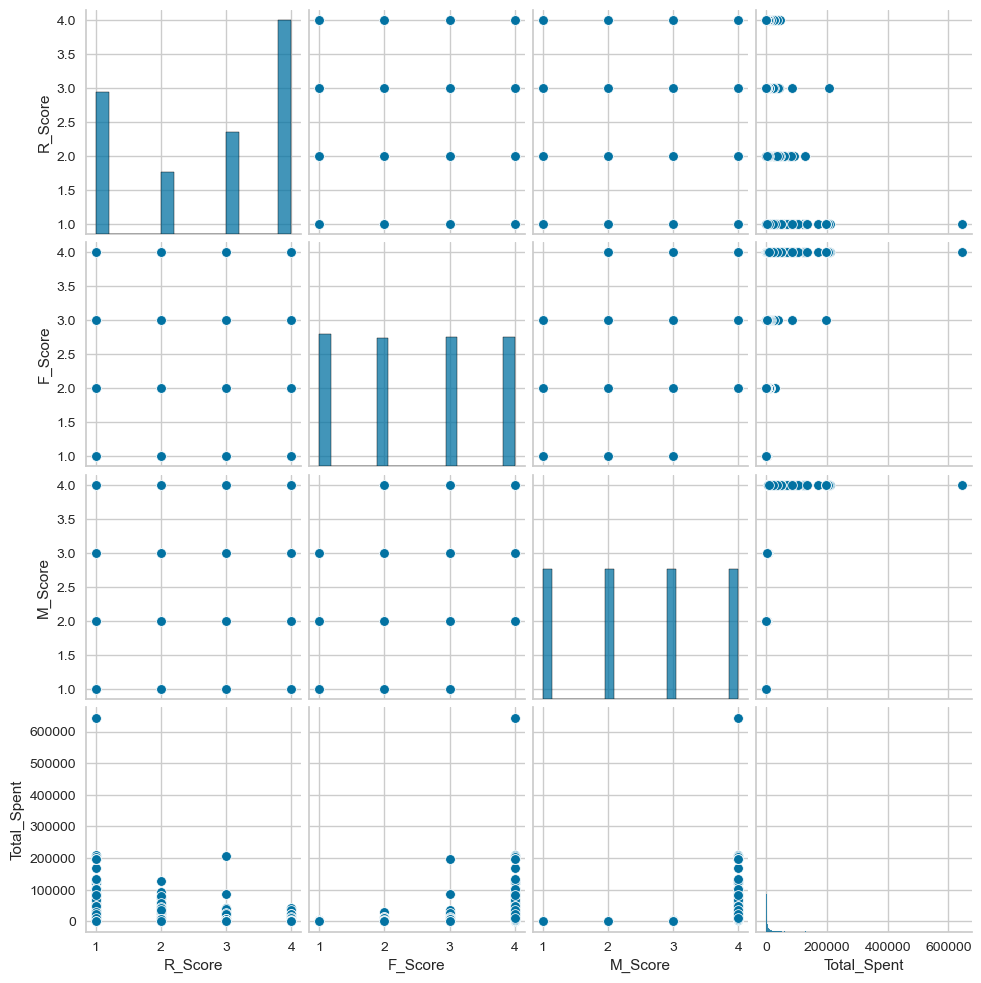

              R_Score   F_Score   M_Score  Total_Spent
R_Score      1.000000 -0.749983 -0.740586    -0.352499
F_Score     -0.749983  1.000000  0.888690     0.410046
M_Score     -0.740586  0.888690  1.000000     0.428232
Total_Spent -0.352499  0.410046  0.428232     1.000000


In [12]:
# policy 
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the RFM scores and total spending
sns.pairplot(user_data[['R_Score', 'F_Score', 'M_Score', 'Total_Spent']])
plt.show()

# Correlation matrix
print(user_data[['R_Score', 'F_Score', 'M_Score', 'Total_Spent']].corr())


In [15]:
user_data['Recommendations'].unique()

array(['Regular Promotions', 'Re-engagement Campaign',
       'Premium Product Line'], dtype=object)

In [35]:
# ContextualEpsilonGreedyBandit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

class ContextualEpsilonGreedyBandit:
    def __init__(self, epsilon, n_actions):
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.context_action_counts = {}
        self.context_action_values = {}
        self.cumulative_rewards = 0
        self.cumulative_regrets = 0
        self.total_actions_taken = 0
        self.mean_rewards = []
        self.mean_regrets = []

    def get_context_key(self, context):
        return tuple(context)

    def select_action(self, context):
        context_key = self.get_context_key(context)
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            if context_key in self.context_action_values:
                return np.argmax(self.context_action_values[context_key])
            else:
                return np.random.randint(self.n_actions)

    def update(self, context, action, reward, optimal_reward):
        context_key = self.get_context_key(context)
        if context_key not in self.context_action_counts:
            self.context_action_counts[context_key] = np.zeros(self.n_actions)
            self.context_action_values[context_key] = np.zeros(self.n_actions)

        # Update action count and values
        self.context_action_counts[context_key][action] += 1
        n = self.context_action_counts[context_key][action]
        value = self.context_action_values[context_key][action]
        self.context_action_values[context_key][action] += (reward - value) / n

        # Track performance
        self.cumulative_rewards += reward
        self.cumulative_regrets += optimal_reward - reward
        self.total_actions_taken += 1
        self.mean_rewards.append(self.cumulative_rewards / self.total_actions_taken)
        self.mean_regrets.append(self.cumulative_regrets / self.total_actions_taken)

# Initialize the bandit
encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_
n_actions = len(np.unique(encoded_actions))
contexts = user_data[['R_Score', 'F_Score', 'M_Score']].values
rewards = (user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)).astype(int)
optimal_rewards = np.max(rewards)  # Assuming the optimal reward is the max reward possible

bandit = ContextualEpsilonGreedyBandit(epsilon=0.1, n_actions=n_actions)

# Update bandit with historical data
for context, action, reward in zip(contexts, encoded_actions, rewards):
    optimal_reward = optimal_rewards  # For simplification, assume the optimal reward is static
    bandit.update(context, action, reward, optimal_reward)


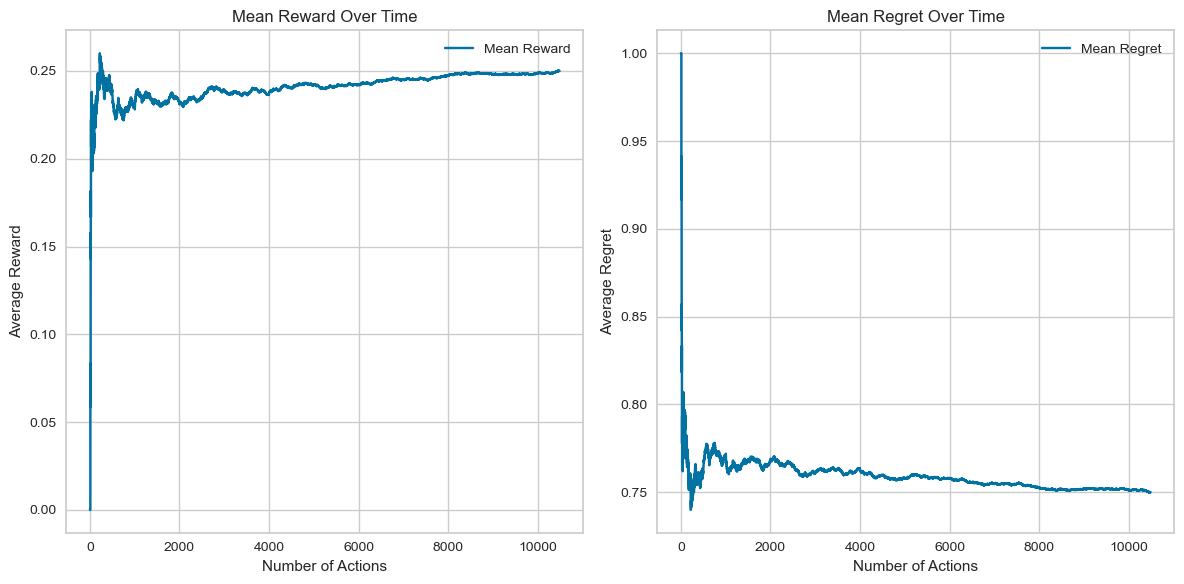

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(bandit.mean_rewards, label='Mean Reward')
plt.title('Mean Reward Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bandit.mean_regrets, label='Mean Regret')
plt.title('Mean Regret Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Average Regret')
plt.legend()

plt.tight_layout()
plt.show()


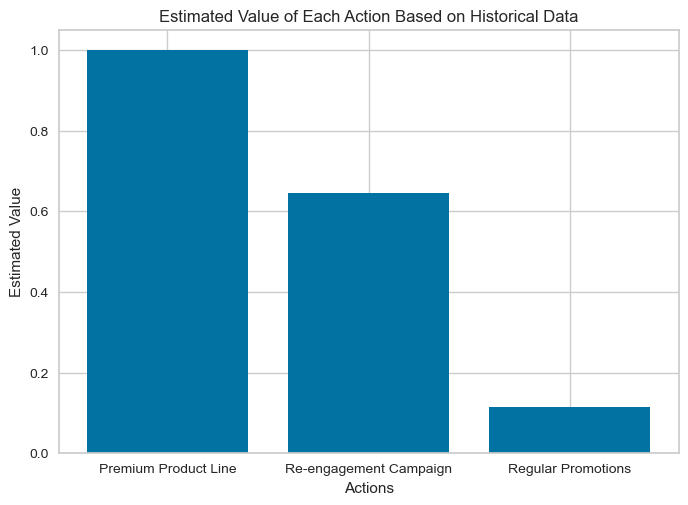

In [17]:
import matplotlib.pyplot as plt

# Plotting the rewards
plt.bar(action_names, bandit.action_rewards)
plt.xlabel('Actions')
plt.ylabel('Estimated Value')
plt.title('Estimated Value of Each Action Based on Historical Data')
plt.show()


In [38]:
# # ContextualThompsonSamplingBandit

import numpy as np
from scipy.stats import beta as beta_dist 
from sklearn.preprocessing import LabelEncoder

class ContextualThompsonSamplingBandit:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.params = {}  # stores alpha and beta for each context and action

    def get_context_key(self, context):
        # Convert context array to a tuple to use as a dictionary key
        return tuple(context)

    def ensure_context_initialized(self, context_key):
        # Initialize with uniform priors if not already initialized
        if context_key not in self.params:
            self.params[context_key] = [(1, 1) for _ in range(self.n_actions)]

    def select_action(self, context):
        context_key = self.get_context_key(context)
        self.ensure_context_initialized(context_key)

        # Debug print to check the structure of self.params[context_key]
        print(f"Params for {context_key}: {self.params[context_key]}")

        # Sample from the Beta distribution for each action
        samples = [beta_dist.rvs(alpha, beta) for alpha, beta in self.params[context_key]]
        return np.argmax(samples)

    def update(self, context, action, reward):
        context_key = self.get_context_key(context)
        self.ensure_context_initialized(context_key)
        alpha, beta = self.params[context_key][action]
        self.params[context_key][action] = (alpha + reward, beta + 1 - reward)


encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_
contexts = user_data[['R_Score', 'F_Score', 'M_Score']].values
rewards = (user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)).astype(int)
n_actions = len(np.unique(encoded_actions))

bandit = ContextualThompsonSamplingBandit(n_actions=n_actions)

# Simulate bandit updates
cumulative_rewards = 0
for context, action, reward in zip(contexts, encoded_actions, rewards):
    chosen_action = bandit.select_action(context)
    actual_reward = reward if action == chosen_action else 0
    bandit.update(context, chosen_action, actual_reward)
    cumulative_rewards += actual_reward

print("Final Cumulative Reward:", cumulative_rewards)


Params for (4, 1, 1): [(1, 1), (1, 1), (1, 1)]
Params for (1, 3, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 1), (1, 1), (1, 2)]
Params for (3, 3, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 1), (1, 1), (1, 3)]
Params for (4, 2, 2): [(1, 1), (1, 1), (1, 1)]
Params for (3, 3, 2): [(1, 1), (1, 2), (1, 1)]
Params for (4, 2, 3): [(1, 1), (1, 1), (1, 1)]
Params for (2, 3, 2): [(1, 1), (1, 1), (1, 1)]
Params for (2, 3, 3): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 3, 4): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 2), (1, 1), (1, 3)]
Params for (3, 3, 3): [(1, 1), (1, 1), (1, 1)]
Params for (1, 1, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 2), (1, 2), (1, 3)]
Params for (3, 2, 2): [(1, 1), (1, 1), (1, 1)]
Params for (1, 4, 4): [(1, 1), (1, 1), (1, 1)]
Params for (1, 4, 4): [(1, 1), (1, 1), (1, 2)]
Params for (1, 4, 3): [(1, 1), (1, 1), (1, 1)]
Params for (1, 2, 2): [(1, 1), (1, 1), (1, 1)]
Params for (1

In [ ]:
ContextualThompsonSamplingBandit = np.mean(cumulative_rewards, axis=0)
linucb_mean_cum_regret = np.mean(cum_regret, axis=0)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(bandit.mean_rewards, label='Mean Reward')
plt.title('Mean Reward Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bandit.cumulative_regrets, label='Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# Assuming actions and rewards are already defined in user_data
encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_

# Rewards should be binary; assuming it's already the case based on the previous context


In [20]:
# Initialize bandit
n_actions = len(np.unique(encoded_actions))
bandit = ThompsonSamplingBandit(n_actions=n_actions)

# Historical update
for action, reward in zip(encoded_actions, user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)):
    bandit.update(action, int(reward))


In [21]:
# evaluation
# Variables to track performance
cumulative_reward = 0
num_actions_taken = 0
optimal_action_rewards = np.zeros(n_actions)

# Find the best action in hindsight
optimal_action = np.argmax(rewards.groupby(encoded_actions).mean())

# Simulation for offline evaluation
for action, reward in zip(encoded_actions, rewards):
    chosen_action = bandit.select_action()
    actual_reward = reward if action == chosen_action else 0
    bandit.update(chosen_action, actual_reward)
    cumulative_reward += actual_reward
    optimal_action_rewards[optimal_action] += reward

# Calculate regret
total_optimal_reward = sum(optimal_action_rewards)
regret = total_optimal_reward - cumulative_reward

# Output results
print("Cumulative Reward:", cumulative_reward)
print("Total Optimal Reward:", total_optimal_reward)
print("Regret:", regret)

Cumulative Reward: 1622
Total Optimal Reward: 2621.0
Regret: 999.0


In [22]:

for action, reward in zip(encoded_actions, rewards):
    chosen_action = bandit.select_action()
    actual_reward = reward if action == chosen_action else 0
    bandit.update(chosen_action, actual_reward)
    cumulative_reward += actual_reward
    num_actions_taken += 1

# Calculate average reward
average_reward = cumulative_reward / num_actions_taken if num_actions_taken > 0 else 0

# Output results
print("Cumulative Reward:", cumulative_reward)
print("Average Reward:", average_reward)

Cumulative Reward: 3267
Average Reward: 0.31161770316673026


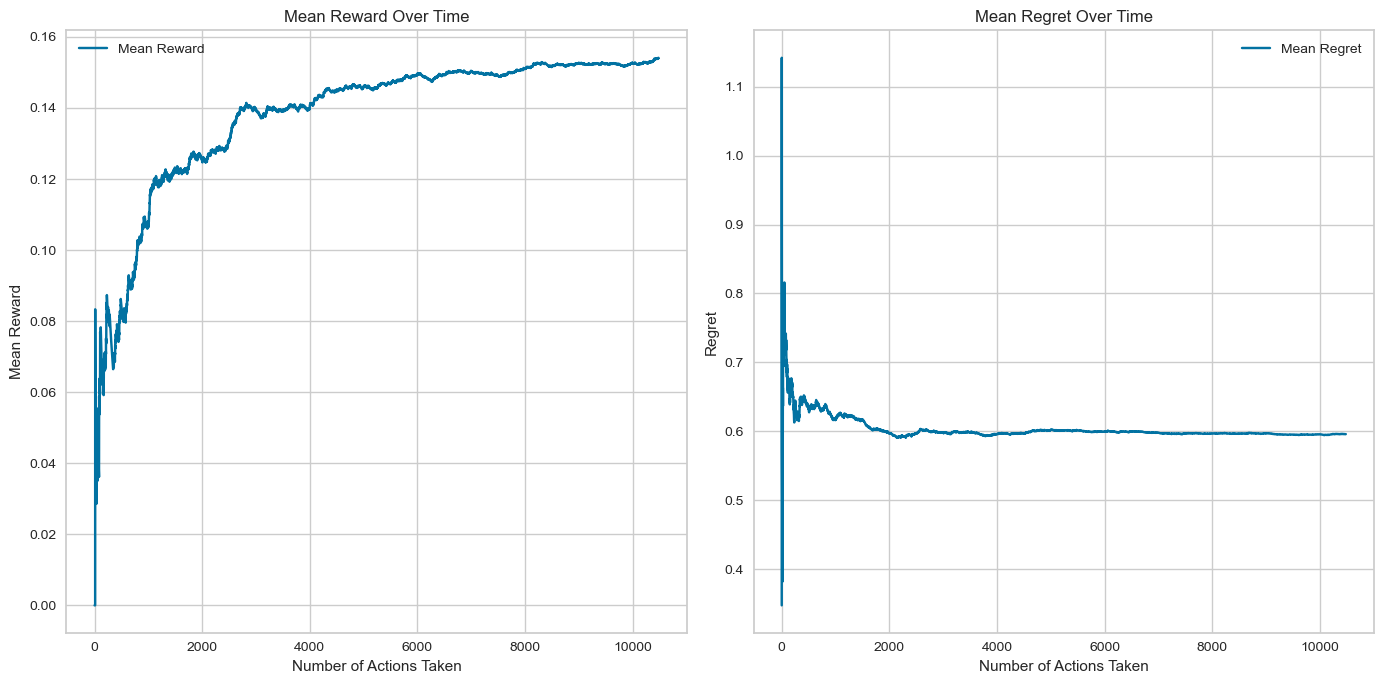

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from sklearn.preprocessing import LabelEncoder

# Assuming 'user_data' and other required data setups are previously defined
encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_
rewards = user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)

class ThompsonSamplingBandit:
    def __init__(self, n_actions):
        self.alphas = np.ones(n_actions)
        self.betas = np.ones(n_actions)

    def select_action(self):
        samples = [beta.rvs(a, b) for a, b in zip(self.alphas, self.betas)]
        return np.argmax(samples)

    def update(self, action, reward):
        self.alphas[action] += reward
        self.betas[action] += (1 - reward)

# Initialize bandit
n_actions = len(np.unique(encoded_actions))
bandit = ThompsonSamplingBandit(n_actions=n_actions)

# Variables to track performance
cumulative_reward = 0
num_actions_taken = 0
optimal_action_rewards = np.zeros(n_actions)
mean_rewards = []
regrets = []
mean_regrets = []


for i, (action, reward) in enumerate(zip(encoded_actions, rewards)):
    chosen_action = bandit.select_action()
    actual_reward = reward if action == chosen_action else 0
    bandit.update(chosen_action, actual_reward)
    cumulative_reward += actual_reward
    num_actions_taken += 1
    
    # Update mean rewards
    mean_reward = cumulative_reward / num_actions_taken
    mean_rewards.append(mean_reward)
    
    # Update regrets for calculating mean regret
    optimal_reward = rewards[encoded_actions == action].mean()  # Estimated optimal reward for the action
    optimal_action_rewards += optimal_reward
    regret = np.sum(optimal_action_rewards) - cumulative_reward
    regrets.append(regret)
    mean_regret = regret / num_actions_taken
    mean_regrets.append(mean_regret)

# Plotting results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards, label='Mean Reward')
plt.title('Mean Reward Over Time')
plt.xlabel('Number of Actions Taken')
plt.ylabel('Mean Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_regrets, label='Mean Regret')
plt.title('Mean Regret Over Time')
plt.xlabel('Number of Actions Taken')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()
